## Ricap

Using rotated to hz + OpenCv border

Basic default transforms

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [70]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from fastai_extensions import *

In [6]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [7]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [8]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [9]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [10]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [11]:
RETRAIN = True
RESIZE_IMAGES = True

In [50]:
MODEL_NAME='cv_reflect_101_ricap'

In [52]:
NB_NUM='03_8_3'

In [14]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: a81b6c9e, DATE: 20191102


In [15]:
#DATE = '20191026'
#UID = '1964891c'

In [16]:
SUB_NUM='9'

In [17]:
img_size=256
bs = 64

In [18]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [19]:
test_names = get_image_files(test_images)

In [20]:
assert len(test_names)==7325

In [21]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [22]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [23]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [24]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [25]:
assert len(df_test)==7325

In [26]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [27]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [28]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [29]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [30]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [31]:
#to check what params object has
#dir(data)

In [32]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [33]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

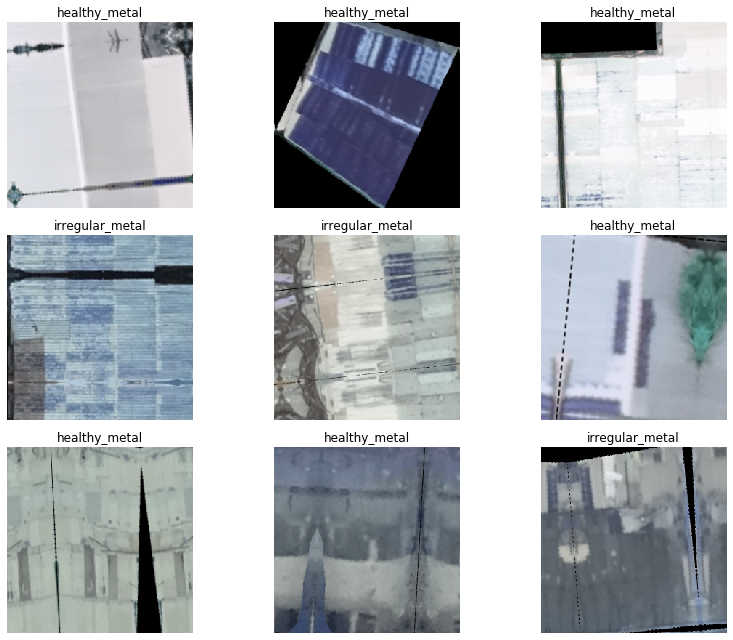

In [34]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [35]:
arch = models.resnet50
arch_name = 'rn50'

Without mixup:
<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.508273 	1.170024 	0.339911 	01:16
1 	0.471699 	0.494651 	0.166297 	01:22
2 	0.439157 	0.417086 	0.152328 	01:23
3 	0.402381 	0.370002 	0.127938 	01:23
4 	0.355355 	0.360440 	0.126608 	01:22
    </pre>

#### Ricap

In [46]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16().ricap()

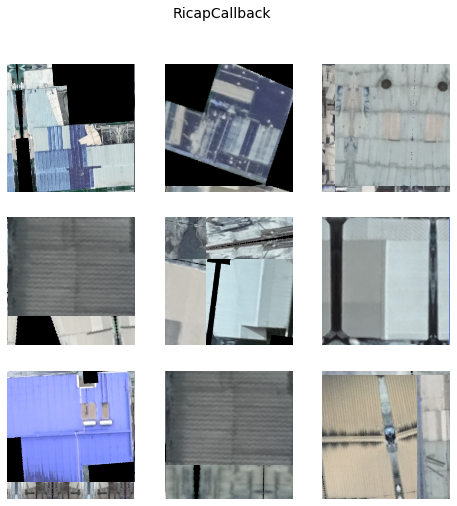

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [71]:
learn.show_tfms()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


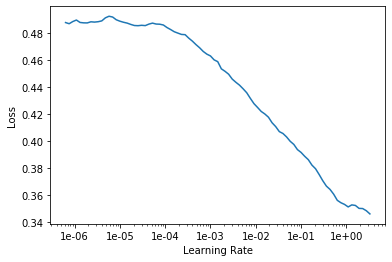

In [43]:
learn.recorder.plot()

In [47]:
lr = 1e-2

In [48]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.238596,0.658154,0.188470,00:58
1,0.170619,0.458652,0.163858,01:03
2,0.155800,0.448271,0.162306,01:01
3,0.153167,0.405904,0.140133,01:09
4,0.150510,0.402641,0.140798,01:09


In [53]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-1-rn50-03_8_3-cv_reflect_101_ricap-20191102-a81b6c9e


In [54]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [55]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

save will save the callback so we dont need to re-add it

In [63]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 functools.partial(<class 'image_data_aug.RicapCallback'>, stack_y=True)]

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 281),
 ('healthy_metal', 'irregular_metal', 99),
 ('incomplete', 'irregular_metal', 59),
 ('concrete_cement', 'healthy_metal', 39),
 ('other', 'healthy_metal', 35),
 ('incomplete', 'healthy_metal', 23),
 ('healthy_metal', 'concrete_cement', 21),
 ('irregular_metal', 'incomplete', 16),
 ('irregular_metal', 'concrete_cement', 15),
 ('concrete_cement', 'incomplete', 11),
 ('incomplete', 'concrete_cement', 11),
 ('concrete_cement', 'irregular_metal', 9),
 ('irregular_metal', 'other', 6),
 ('healthy_metal', 'incomplete', 3),
 ('other', 'irregular_metal', 3),
 ('healthy_metal', 'other', 2)]

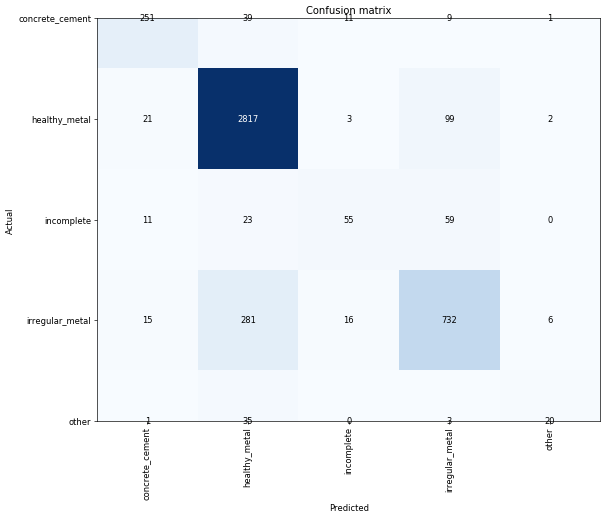

In [57]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [58]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


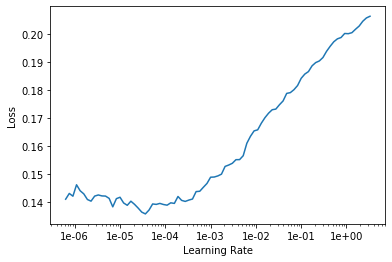

In [59]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(5, slice(5e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.148035,0.377950,0.132594,01:14
1,0.144400,0.405524,0.145676,01:15
2,0.143569,0.383562,0.139246,01:25
3,0.136993,0.367715,0.126386,01:28
4,0.131488,0.367835,0.127273,01:25


In [65]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [66]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [67]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.140884,0.382436,0.135255,01:12
1,0.139583,0.412303,0.147894,01:13
2,0.141273,0.377542,0.139690,01:13
3,0.131345,0.377521,0.128603,01:15
4,0.132052,0.364307,0.126608,01:14


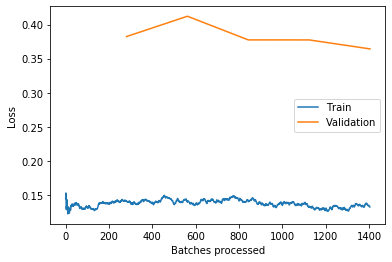

In [68]:
learn.recorder.plot_losses()

In [72]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [89]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/train/rotated/clipped/256;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/train/rotated/clipped/256;

Test: LabelList (15325 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64

In [90]:
learn = learn.to_fp32()

In [91]:
learn.export(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [92]:
print(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-2-rn50-03_8_3-cv_reflect_101_ricap-20191102-a81b6c9e


In [93]:
learn.export()

### inference

In [125]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [126]:
len(test_dataset)

15325

In [127]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [128]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [129]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [130]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [131]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [132]:
len(learn.dl(DatasetType.Test))

240

Get number of items in the Valid dataset (in DeviceDataLoader)

In [133]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [134]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [135]:
labels = np.argmax(preds, 1)

In [136]:
len(preds)

15325

In [137]:
preds[0].tolist()

[0.1802869290113449,
 0.7892442345619202,
 0.004597105551511049,
 0.02384103275835514,
 0.0020307679660618305]

In [138]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [139]:
len(labels)

15325

In [140]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [141]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [142]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [143]:
test_predictions[0]

'healthy_metal'

In [144]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [145]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [146]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [147]:
preds_list[0]

[0.1802869290113449,
 0.7892442345619202,
 0.004597105551511049,
 0.02384103275835514,
 0.0020307679660618305]

In [148]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [149]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [150]:
df.head()

,id,pred
0,7a4d9168,"[0.1802869290113449, 0.7892442345619202, 0.004..."
1,7a4ae922,"[0.037028513848781586, 0.919670820236206, 0.00..."
2,7a48ca98,"[0.019819030538201332, 0.43586158752441406, 0...."
3,7a49c614,"[0.006386504974216223, 0.9276576042175293, 0.0..."
4,7a4dd4f2,"[0.0026269895024597645, 0.9048902988433838, 0...."


In [151]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [152]:
pred_df.insert(loc=0, column='id', value=ids)

In [153]:
pred_df.columns = cols

In [154]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.180287,0.789244,0.004597,0.023841,0.002031
1,7a4ae922,0.037029,0.919671,0.003366,0.037371,0.002564
2,7a48ca98,0.019819,0.435862,0.016473,0.524072,0.003775
3,7a49c614,0.006387,0.927658,0.003356,0.060302,0.002298
4,7a4dd4f2,0.002627,0.904890,0.003485,0.079143,0.009855


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [155]:
pred_ids=pred_df['id'].values.tolist()

In [156]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [157]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [158]:
baseline_ids=df_baseline['id'].values.tolist()

In [159]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [160]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [161]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [162]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.180287,0.789244,0.004597,0.023841,0.002031,7a4d9168
1,7a4ae922,0.037029,0.919671,0.003366,0.037371,0.002564,7a4ae922
2,7a48ca98,0.019819,0.435862,0.016473,0.524072,0.003775,7a48ca98
3,7a49c614,0.006387,0.927658,0.003356,0.060302,0.002298,7a49c614
4,7a4dd4f2,0.002627,0.904890,0.003485,0.079143,0.009855,7a4dd4f2


In [163]:
pred_df=pred_df.sort_values('id_cat')

In [164]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.005936,0.966846,0.004311,0.018921,0.003986,7a4d630a
716,7a4d630a,0.005936,0.966846,0.004311,0.018921,0.003986,7a4d630a
764,7a4bbbd6,0.003612,0.969391,0.003138,0.021767,0.002091,7a4bbbd6
8089,7a4bbbd6,0.003612,0.969391,0.003138,0.021767,0.002091,7a4bbbd6
1841,7a4ac744,0.006516,0.794673,0.004865,0.191078,0.002868,7a4ac744


In [165]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [168]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [170]:
assert len(pred_df)==7325

In [171]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [1]:
### Submission 2: 0.4988

In [16]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

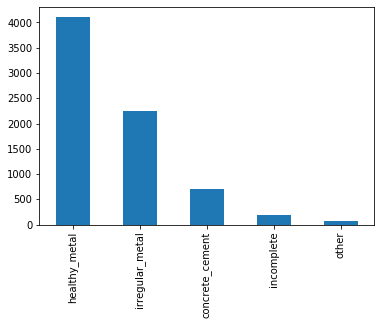

In [172]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")